# House Prices: Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

### Competition Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills
- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting

## 1. importing libraries&dataset

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_train = pd.read_csv("./train.csv", index_col="Id")
df_test = pd.read_csv("./test.csv", index_col="Id")

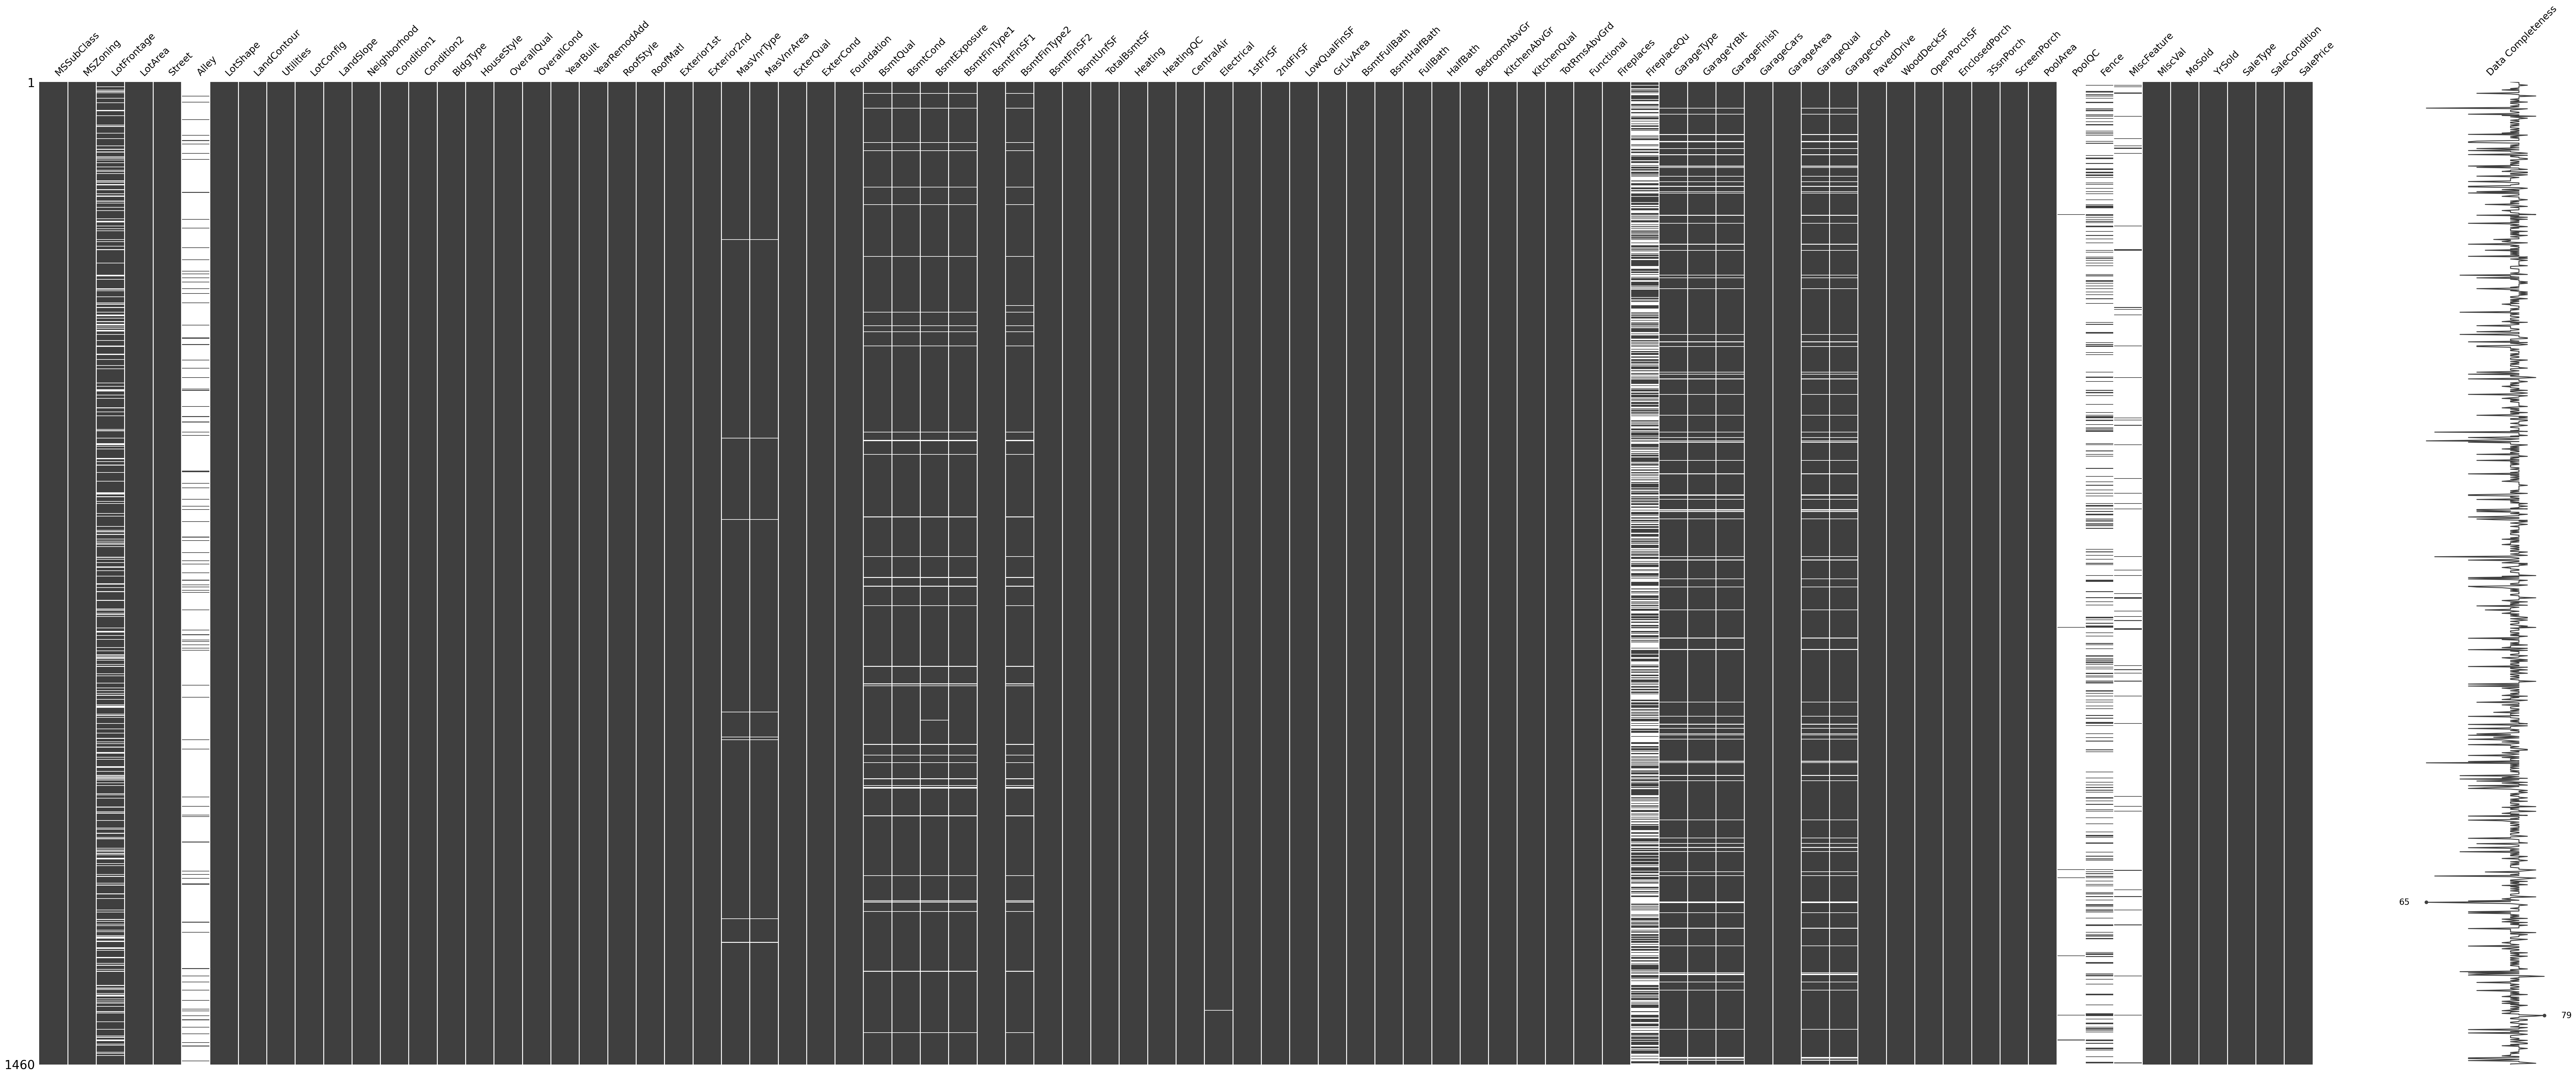

In [3]:
msno.matrix(df_train, figsize=(75, 30), labels=True) # so much null (white space)

## 2. Data Preprocessing (Feature Engineering)

In [4]:
df = pd.concat([df_train, df_test], axis=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [5]:
drop_col = ["Alley", "Neighborhood", "BsmtFinSF2", "FireplaceQu", "MiscFeature"]
val_col = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
binary_col = ["PoolQC", "Fence"]
cat_col = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", 
           "GarageQual", "GarageCond", "MasVnrType"]

In [6]:
df = df.drop(columns=drop_col)

In [7]:
for i in val_col: 
    df[i].fillna(0, inplace=True)

In [8]:
for i in cat_col: 
    df[i] = df[i].fillna("No")

In [9]:
for i in binary_col: 
    df.fillna(0, inplace=True)
    df[i] = df[i].apply(lambda x: 0 if x == 0 else 1)

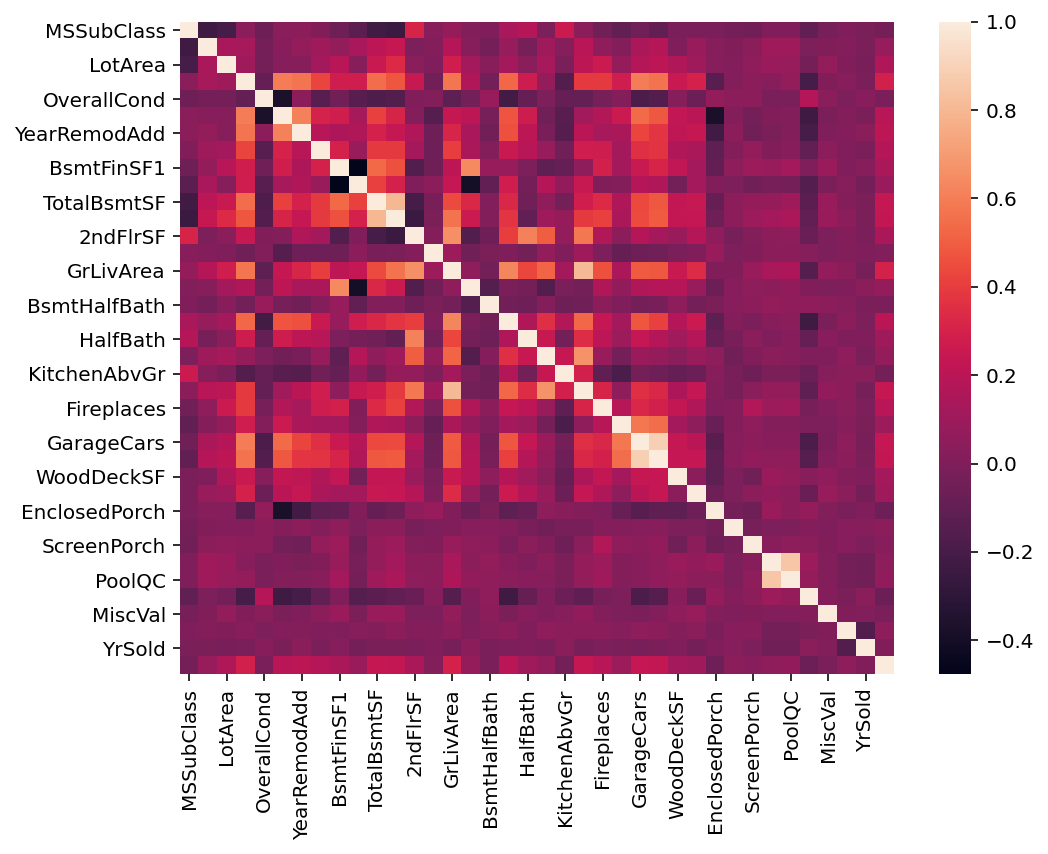

In [10]:
cor_df = df.select_dtypes(np.number).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_df)

## 3. Data Visualization & EDA

In [11]:
df = pd.get_dummies(df.iloc[:, df.columns != "SalePrice"])
X = df.iloc[:df_train.shape[0], :]
y = df_train["SalePrice"]
X_test = df.iloc[df_train.shape[0] :, :]

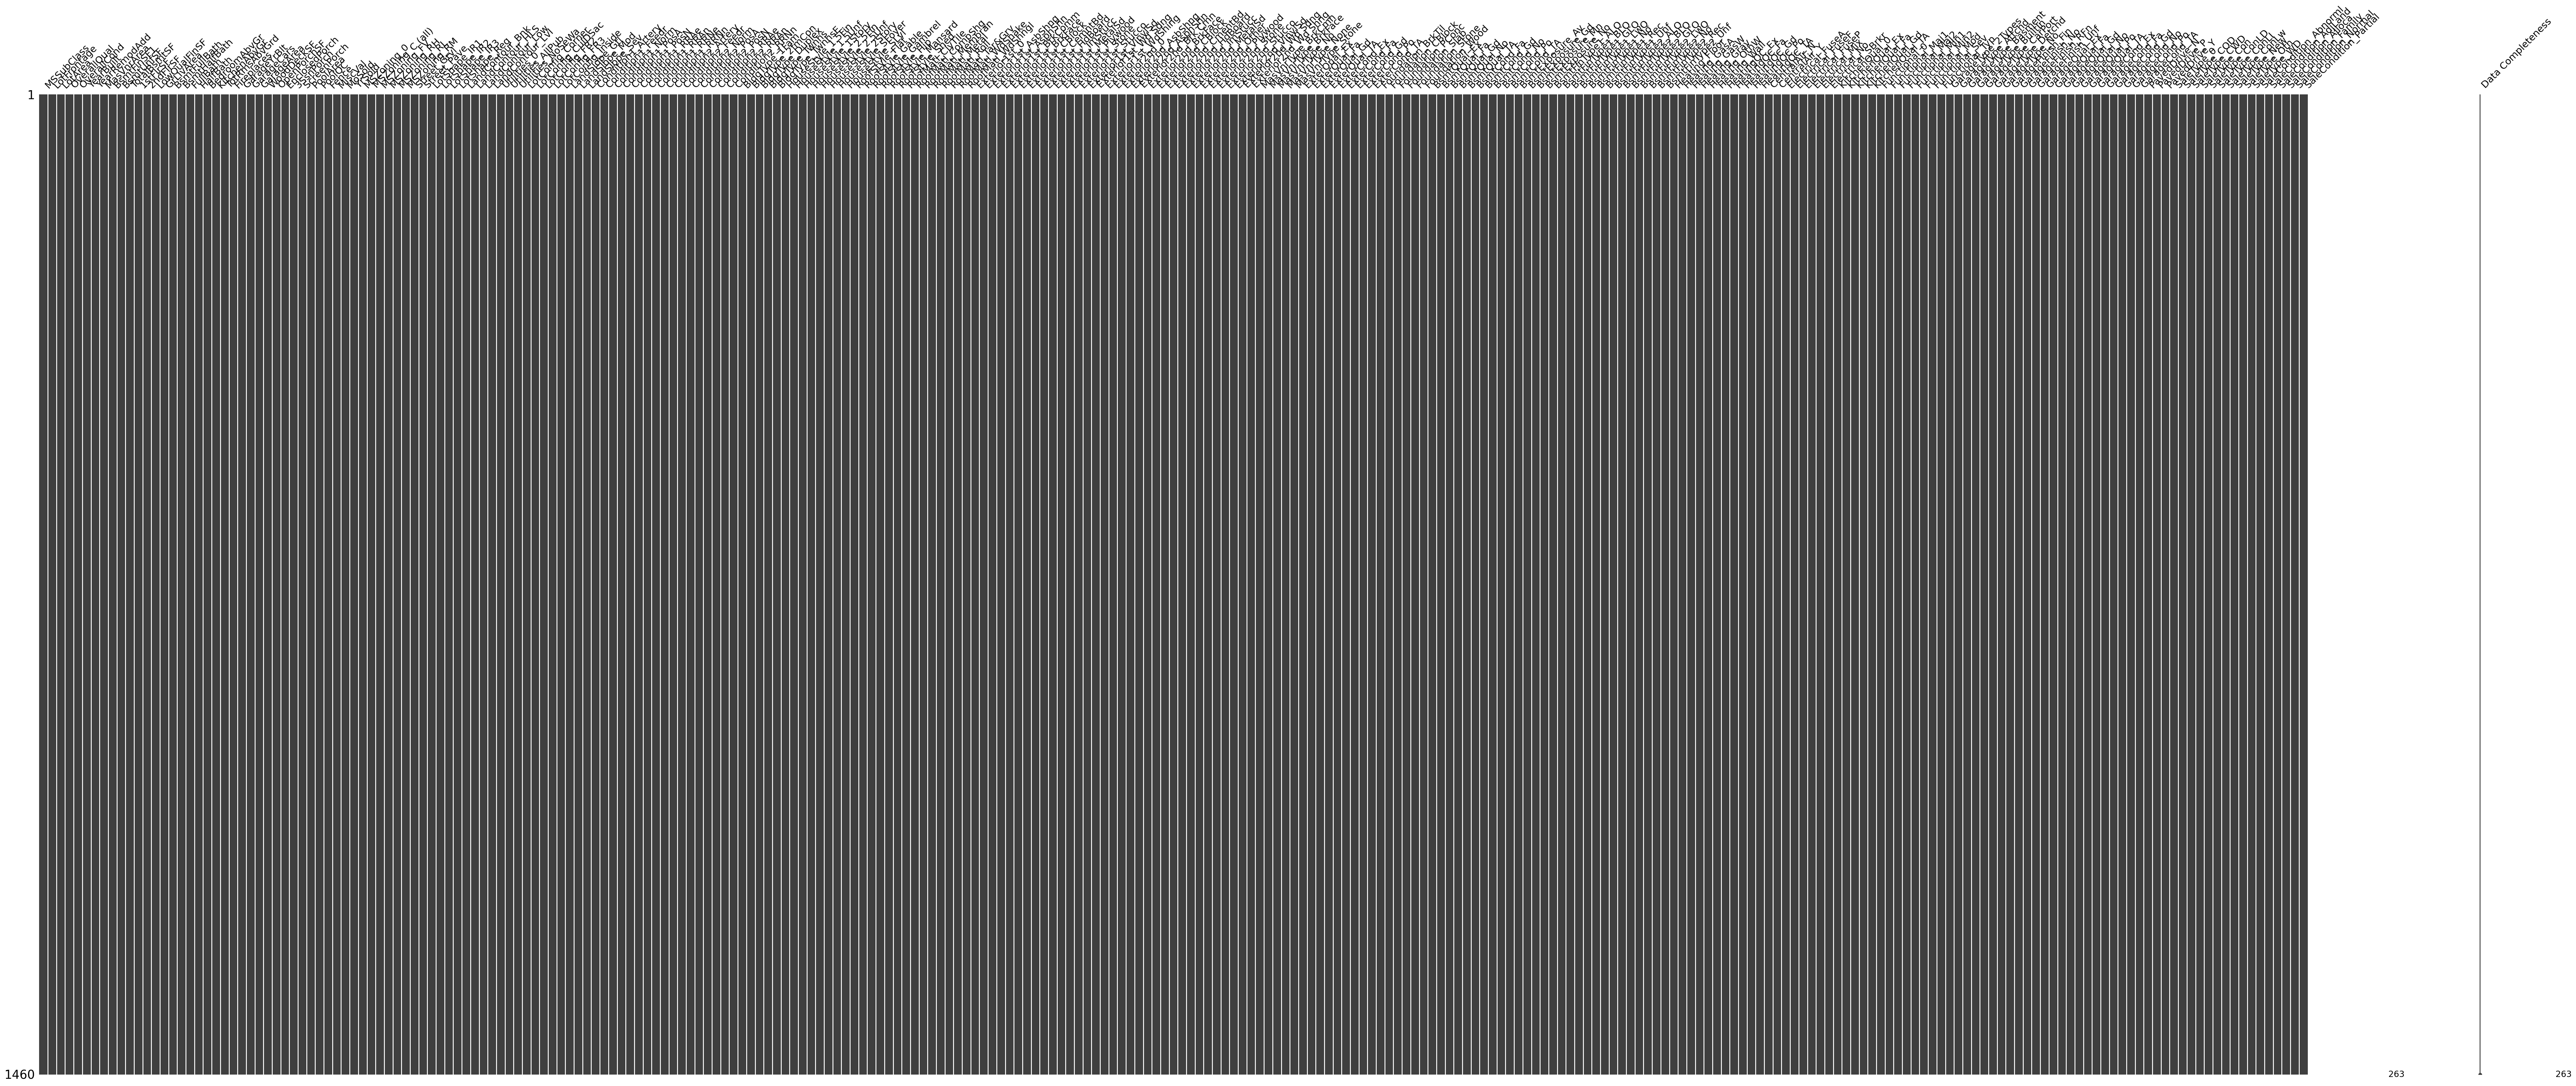

In [12]:
msno.matrix(X, figsize=(75, 30), labels=True) #NA checked

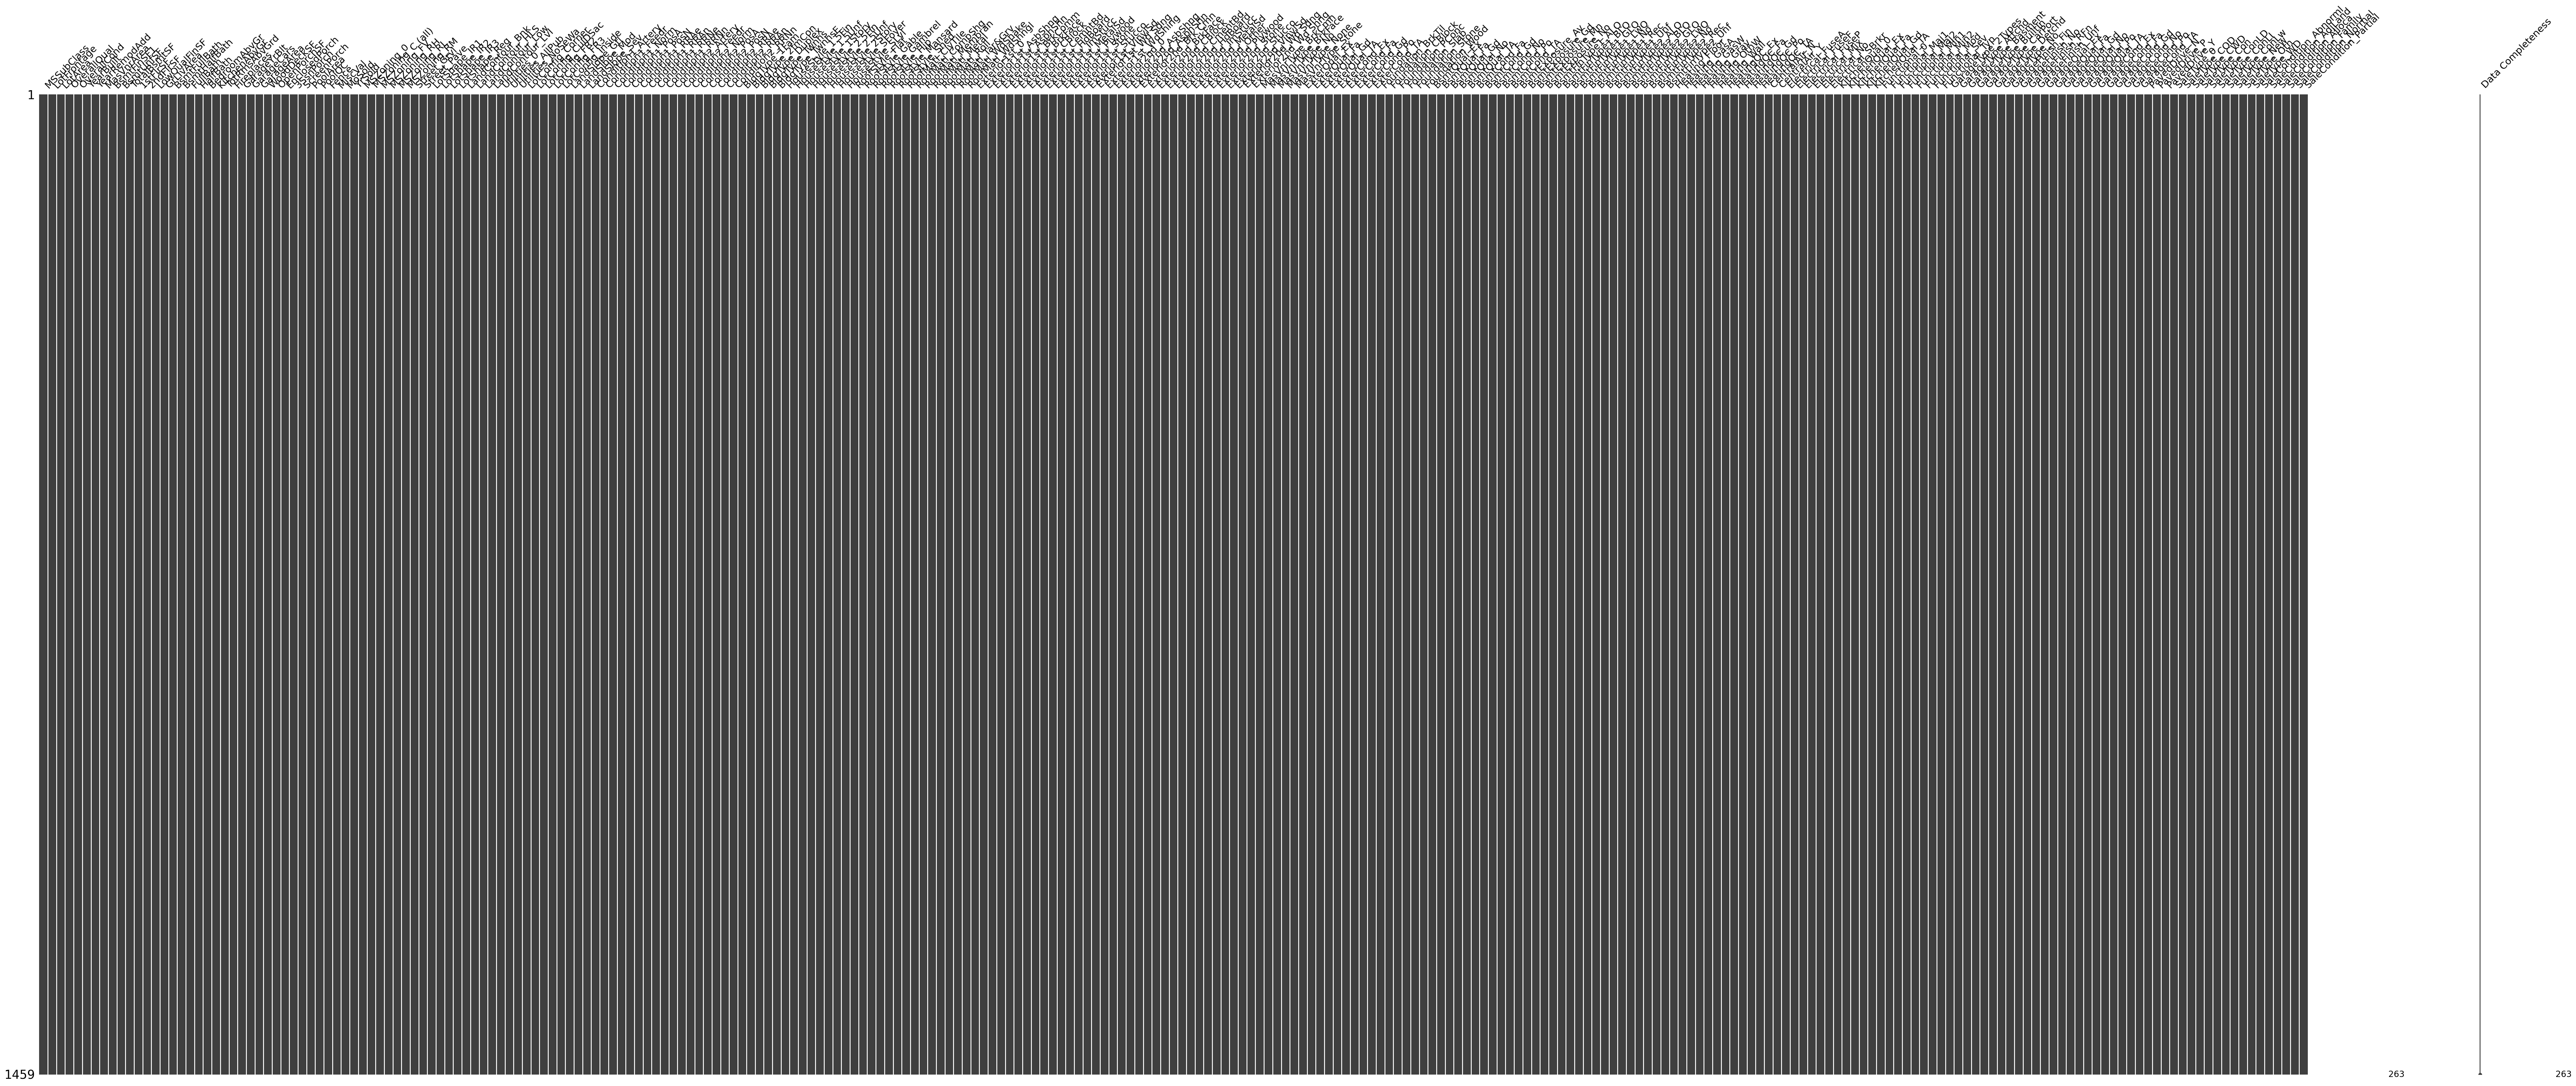

In [13]:
msno.matrix(X_test, figsize=(75, 30), labels=True)

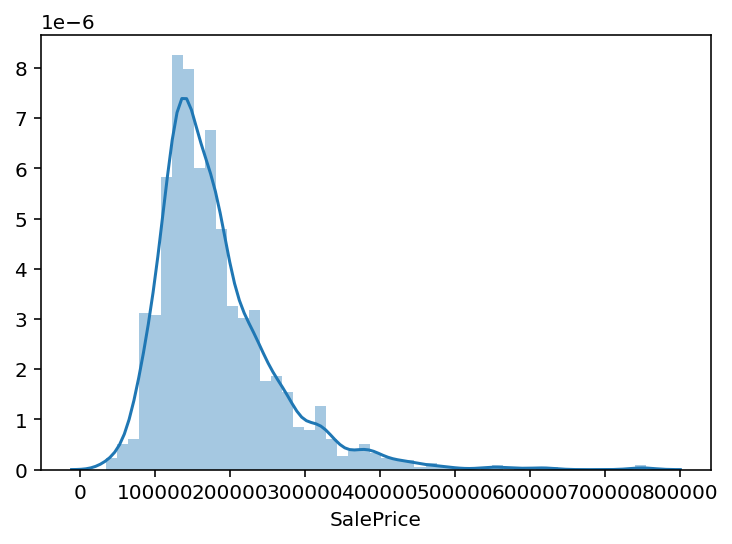

In [14]:
sns.distplot(y)

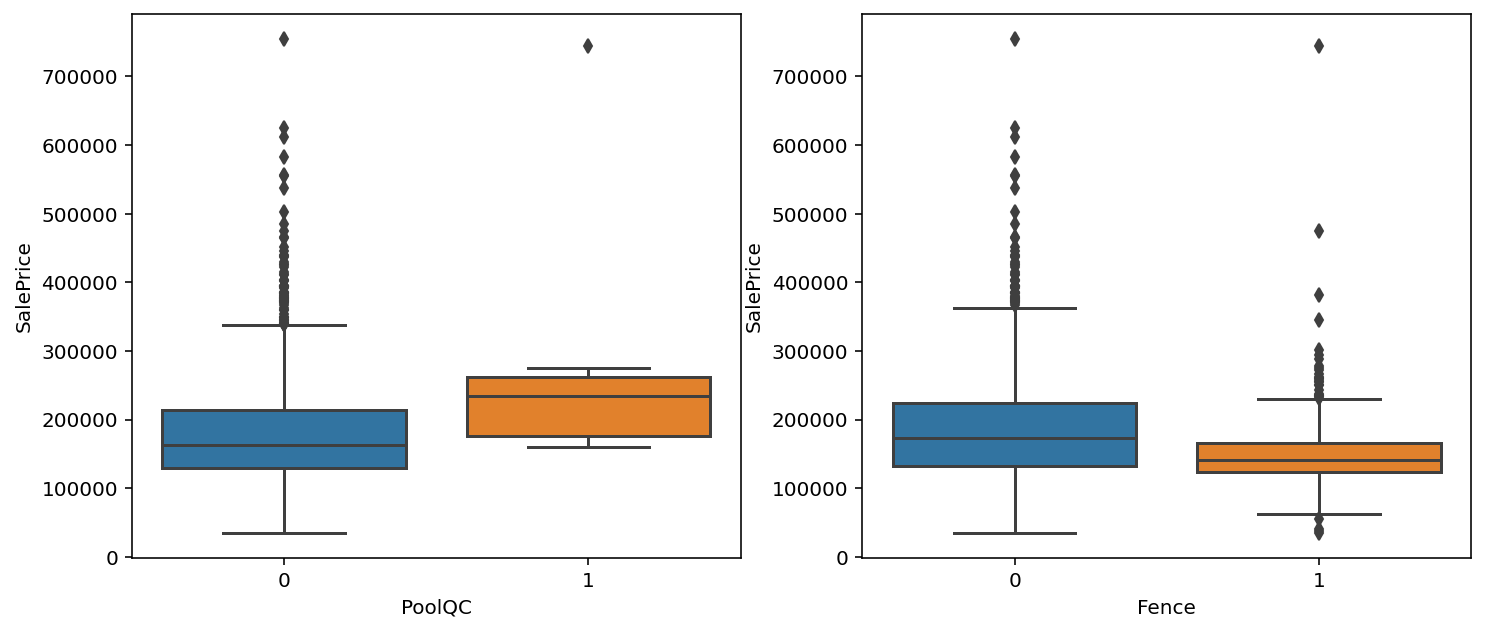

In [15]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
sns.boxplot(x=X["PoolQC"], y=y)
fig.add_subplot(122)
sns.boxplot(x=X["Fence"], y=y)

## 4. training/validation split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=101)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape)

(1314, 263) (146, 263) (1459, 263)


## 5. Modeling
- Linear Regression
    - [Ridge Regression (L2)](#Ridge-Regression)
    - [Lasso Regression (L1)](#Lasso-Regression)
- [XGBoost](#XGBoost)
- [LightGBM](#LightGBM)

### Ridge Regression

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [20]:
alpha_L2 = [15, 20, 30, 35, 40, 45, 50, 55]
parameters = {'alpha':alpha_L2, 'solver':('svd', 'saga')}
clf = GridSearchCV(Ridge(random_state=101), parameters)
clf.fit(X_train.select_dtypes(np.number), y_train)

GridSearchCV(estimator=Ridge(random_state=101),
             param_grid={'alpha': [15, 20, 30, 35, 40, 45, 50, 55],
                         'solver': ('svd', 'saga')})

In [21]:
clf.best_params_

{'alpha': 40, 'solver': 'svd'}

In [22]:
print(f'train score: {clf.best_score_}')
print(f'validation score: {clf.score(X_val, y_val)}')

train score: 0.8071339693782947
validation score: 0.8984536296811098


In [23]:
y_pred = clf.predict(X_test)
y_pred

array([105463.48879026, 140834.70430684, 176251.02887238, ...,
       171105.94828127, 115844.73261922, 239284.54271485])

In [24]:
sub_1 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
sub_1.head()

,Id,SalePrice
0,1461,105463.488790
1,1462,140834.704307
2,1463,176251.028872
3,1464,192507.993246
4,1465,184933.478525


In [25]:
# sub_1.to_csv("submission_Ridge.csv", index=False)

### Lasso Regression

In [26]:
from sklearn.linear_model import Lasso

In [27]:
alpha_L1 = [200, 220, 250, 280, 300]
parameters = {'alpha':alpha_L1}
clf = GridSearchCV(Lasso(random_state=101), parameters)
clf.fit(X_train.select_dtypes(np.number), y_train)

GridSearchCV(estimator=Lasso(random_state=101),
             param_grid={'alpha': [200, 220, 250, 280, 300]})

In [28]:
clf.best_params_

{'alpha': 220}

In [29]:
print(f'train score: {clf.best_score_}')
print(f'validation score: {clf.score(X_val, y_val)}')

train score: 0.8150176039088178
validation score: 0.8995104904969191


In [30]:
y_pred = clf.predict(X_test)

sub_2 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
sub_2.head()

,Id,SalePrice
0,1461,111286.683811
1,1462,146022.906452
2,1463,178291.736006
3,1464,191521.834949
4,1465,185872.554312


In [31]:
# sub_2.to_csv("submission_Lasso.csv", index=False)

### XGBoost

In [32]:
from xgboost import XGBRegressor

In [34]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [35]:
xgboost.fit(X_train, y_train)

[09:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=3460, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=27, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
print(f'train score: {xgboost.score(X_train, y_train)}')
print(f'validation score: {xgboost.score(X_val, y_val)}')

train score: 0.989226936295566
validation score: 0.9114293488117455


In [37]:
y_pred = xgboost.predict(X_test)

sub_3 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
sub_3.head()

,Id,SalePrice
0,1461,123139.734375
1,1462,164281.390625
2,1463,182175.156250
3,1464,190207.359375
4,1465,185933.593750


In [38]:
# sub_3.to_csv("submission_XGBoost.csv", index=False)

### -- optional XGBoost with gridsearch (find best parameters)

In [46]:
# parameters = {'learning_rate': [0.005, 0.006], 'n_estimators':[4000, 4500, 5000], 'max_depth':[5, 6, 8], 'reg_alpha':[0.001, 0.005, 0.01]}
# clf = GridSearchCV(XGBRegressor(min_child_weight=0, gamma=0, 
#                                         colsample_bytree=0.7, objective='reg:linear', nthread=-1,
#                                         scale_pos_weight=1, subsample=.7, seed=27), parameters)
# clf.fit(X_train.select_dtypes(np.number), y_train)

[12:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[12:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[12:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[13:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[13:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[13:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[13:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[14:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[14:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:13:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[14:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[14:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=0,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=1, seed=27, subsample=0.7,
                

In [47]:
# clf.best_params_

# # {'learning_rate': 0.005,
# #  'max_depth': 5,
# #  'n_estimators': 4500,
# #  'reg_alpha': 0.005}

{'learning_rate': 0.005,
 'max_depth': 5,
 'n_estimators': 4500,
 'reg_alpha': 0.005}

In [48]:
# print(f'train score: {clf.best_score_}')
# print(f'validation score: {clf.score(X_val, y_val)}')

# # train score: 0.8856452700799474
# # validation score: 0.9125119162731631

train score: 0.8856452700799474
validation score: 0.9125119162731631


In [49]:
# y_pred = clf.predict(X_test)

# sub_3 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
# sub_3.head()

,Id,SalePrice
0,1461,124272.539062
1,1462,162916.937500
2,1463,185667.171875
3,1464,190985.546875
4,1465,183452.578125


In [50]:
# sub_3.to_csv("submission_XGBoost.csv", index=False)